In [ ]:
#datasets from:
#https://www.kaggle.com/datasets/atulyakumar98/test-dataset?sort=most-comments
#https://www.kaggle.com/datasets/phylake1337/fire-dataset
#https://github.com/DeepQuestAI/Fire-Smoke-Dataset

## Library load

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Portofolio/fire_detection_quant_aware

/content/drive/MyDrive/Portofolio/fire_detection_quant_aware


In [ ]:
!ls

Callbacks	      custom_cnn3.ipynb    quant_saved_models
cluster_saved_models  old		   saved_models
combined	      pruned_saved_models  TFLite_Models
combined_test	      pruning.ipynb	   weight_clustering.ipynb


In [ ]:
 !pip install  tensorflow-model-optimization


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 237 kB 29.6 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import glob

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from PIL import Image
from matplotlib import image as plt_image
import cv2

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input 
#mobilenet expects inputs in the range [-1 1] of float data type

from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout
from tensorflow.keras import Sequential 
#https://keras.io/api/applications/mobilenet/ #mobilenet explanation

In [ ]:
import tensorflow_model_optimization as tfmot


In [ ]:
np.random.seed(42)# keras seed fixing 
tf.random.set_seed(42)# tensorflow seed fixing

## Dataset Information

In [ ]:
glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/*") #our two file folders

['/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/fire',
 '/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/not_fire']

### train and validation data

In [ ]:
print("number of images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/*/*")))
print("number of fire images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/fire/*")))
print("number of not fire images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined/not_fire/*")))

number of images in total 3450
number of fire images in total 1765
number of not fire images in total 1685


### test data

In [ ]:
glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*")

['/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/fire',
 '/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/not_fire']

In [ ]:
print("number of images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))
print("number of fire images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/fire/*")))
print("number of not fire images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/not_fire/*")))

number of images in total 200
number of fire images in total 100
number of not fire images in total 100


## Hyperparameters

In [ ]:
class hyperparams:
  def __init__(self):
    self.dim2d = (48,48) #image dimensions we want downscale
    self.dim3d = (48,48,3) #128 is the minimum for mobilenet
    self.batch_size = 64
    self.no_epochs = 50#30
    self.lr = 1e-3
  
hparams =  hyperparams()
print(hparams.dim2d,hparams.dim3d)
hparams.lr

(48, 48) (48, 48, 3)


0.001

##Data Augmentation

### pre augmentation images

In [ ]:
!ls combined  

fire  not_fire


uint8
(480, 852, 3)


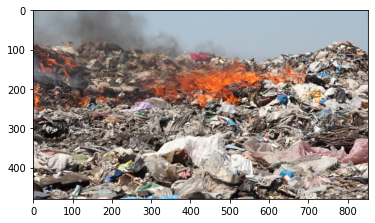

In [ ]:
# load and display an image with Matplotlib
# load image as pixel array
img = plt_image.imread("combined/fire/" + "1.jpg")
# summarize shape of the pixel array
print(img.dtype)
print(img.shape)

# display the array of pixels as an image
plt.imshow(img)
plt.show()

uint8
(1087, 1500, 3)


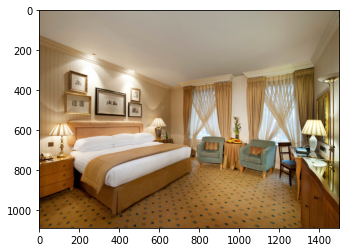

In [ ]:
# load and display an image with Matplotlib
# load image as pixel array
img = plt_image.imread("combined/not_fire/" + "1.jpg")
# summarize shape of the pixel array
print(img.dtype)
print(img.shape)

# display the array of pixels as an image
plt.imshow(img)
plt.show()

### augmentation and preprocess


In [ ]:
def preproc(inp):#custom one without using tf functions
  return (inp*1.0/255)

In [ ]:
train_datagen = ImageDataGenerator(#featurewise_center=True,
                             rotation_range=(0-30),
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.5,1.5],
                             shear_range=0.2, 
                             zoom_range=0.2,
                             channel_shift_range=0.2,
                             horizontal_flip=True, 
                             #vertical_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15,
                             preprocessing_function=preproc,
                             
                             dtype=float)#use 0.15 of our data for validation

test_datagen = ImageDataGenerator(
                                  dtype=float,
                                  preprocessing_function=preproc
                                  ) #no augmentation for test #there is a different folder structure for testing



### post augmentation images and generator creation 

In [ ]:
train_generator = train_datagen.flow_from_directory(
    "combined",
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='binary',
    shuffle=True,
    color_mode="rgb",
    interpolation="bilinear",
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    "combined", # same directory as training data
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='binary',
    shuffle=False,
    color_mode="rgb",
    interpolation="bilinear",
    subset='validation') # set as validation data


test_generator = test_datagen.flow_from_directory(
    "combined_test", 
    target_size=hparams.dim2d,
    batch_size=hparams.batch_size,
    class_mode='binary',
    interpolation="bilinear",
    color_mode="rgb",
    ) # set as test data

Found 2934 images belonging to 2 classes.
Found 516 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [ ]:
 img = next(train_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

In [ ]:
 img = next(validation_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

In [ ]:
 img = next(test_generator)[0]
 print(img.shape)
 print(img.dtype)
 img.min(),img.max()

(64, 48, 48, 3)
float32


(0.0, 1.0)

## Model creation

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(16, (3, 3), activation='relu', input_shape=hparams.dim3d))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(1, activation='sigmoid')) # 2 classes

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 16)        448       
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 16)        2320      
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 16)       64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 16)       0         
 )                                                               
                                                        

**IMPORTANT**

Each 32float param will be converted to an 8bit int one. Thus, for the QUANTIZED MODEL we will need roughly 71.3KB/0.06 MB of memory (73,041/(1024^2)) for the weights. The quantized tflite model will need more space though in order to store the architecture information and the quantization parameters that are needed.

## Callbacks

In [ ]:
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', 
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_freq = "epoch", #check and save at the end of the epoch   
                             save_weights_only=False,   #save model too   
                             )#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 7, #wait 7 epochs before you restore best weights and stop model trainng
                           mode="min", 
                           verbose = 1,
                           min_delta=0.01,
                           restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs

#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/early_stopping/



## Learning Rate and Optimizer

In [ ]:
#https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
#time decay
from tensorflow.keras.optimizers import Adam



def lr_time_based_decay(epoch, lr):
    initial_learning_rate = hparams.lr 
    epochs = hparams.no_epochs
    decay = initial_learning_rate / (epochs) *1000

    return lr * 1 / (1 + decay * epoch)

time_decay_learning_rate = tf.keras.callbacks.LearningRateScheduler (lr_time_based_decay, verbose=1) #CALLBACK 
callbacks = [checkpoint, early_stop,time_decay_learning_rate]
optimizer = Adam(learning_rate=hparams.lr)

In [ ]:
# #https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
# #step decay
# import math
# from tensorflow.keras.optimizers import Adam



# def lr_step_decay(epoch, lr):
#     initial_learning_rate = hparams.lr #0.1
#     drop_rate = 0.5 #halfs the learning rate
#     epochs_drop = 10.0
#     return initial_learning_rate * math.pow(drop_rate, math.floor(epoch/epochs_drop))

# step_decay_learning_rate = tensorflow.keras.callbacks.LearningRateScheduler (lr_step_decay, verbose=1) #CALLBACK 
# callbacks = [model_checkpoint_callback,model_earlystop_callback,step_decay_learning_rate]
# optimizer = Adam(learning_rate=hparams.lr)

In [ ]:
# #no policies

# #optimizer 

# from tensorflow.keras.optimizers import Adam
# callbacks = [checkpoint, early_stop]
# optimizer = Adam(learning_rate=hparams.lr)

## Model training

In [ ]:
model.compile(optimizer=optimizer, loss = 'binary_crossentropy', metrics = 'accuracy')

In [ ]:
history = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // hparams.batch_size,
            validation_data = validation_generator, 
            validation_steps = validation_generator.samples // hparams.batch_size,
            epochs = hparams.no_epochs,
            callbacks=[callbacks])



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/50
45/45 [==============================] - ETA: 0s - loss: 0.5703 - accuracy: 0.7530 
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to Callbacks/weights-improvement-01-0.52.hdf5
45/45 [==============================] - 1248s 28s/step - loss: 0.5703 - accuracy: 0.7530 - val_loss: 0.6829 - val_accuracy: 0.5156 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009803922034288739.
Epoch 2/50
45/45 [==============================] - ETA: 0s - loss: 0.4720 - accuracy: 0.7990
Epoch 2: val_accuracy improved from 0.51562 to 0.57422, saving model to Callbacks/weights-improvement-02-0.57.hdf5
45/45 [==============================] - 51s 1s/step - loss: 0.4720 - accuracy: 0.7990 - val_loss: 0.6462 - val_accuracy: 0.5742 - lr: 9.8039e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009426848219635967.
Epoch 3/50
45/45 [==============================] - E

In [ ]:
model.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

8/8 [==============================] - 7s 826ms/step - loss: 0.3240 - accuracy: 0.8633


[0.32400792837142944, 0.86328125]

In [ ]:
model.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

3/3 [==============================] - 86s 43s/step - loss: 0.3659 - accuracy: 0.8542


[0.36585044860839844, 0.8541666865348816]

In [ ]:
model.save("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/saved_models/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fire_detection_quant_aware/saved_models/assets


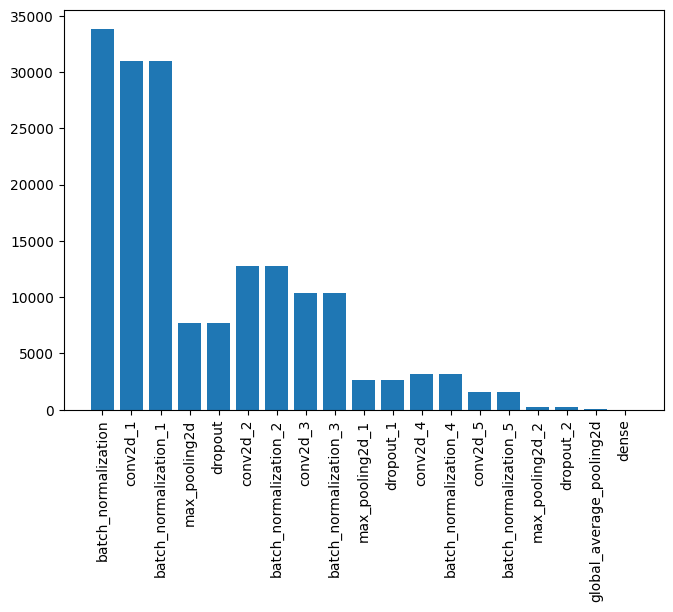

In [ ]:
#Evaluate the tensor size for the intermediate tensors (H*W*D)

fig = plt.figure(dpi=100)

ax = fig.add_axes([0,0,1,1])

l_idx   = []
l_sizes = []

for layer in model.layers[1:]:
  shape = layer.output_shape
  shape = np.delete(shape, 0)
  size  = np.prod(shape)
  l_idx   = np.append(l_idx, layer.name)
  l_sizes = np.append(l_sizes, size)

ax.bar(l_idx, l_sizes)
plt.xticks(rotation='vertical')
plt.show()

**IMPORTANT**

We can have a rough estimation of the tensor arena by adding the size of the biGgest tensor multiplied by 2 and the size of the input and output. For our case the biggest tensor has roughly 35k parameters which means that when quantized it will need 35k *8bit size = 35 KB(35*1024B), 70KB when multiplied. As for the input it will be 48*48*3 parameters of 8bit each. Thus the input will need 7KB(7*1024). We will also need 1B for the output. In reality tensor arena will need more space cause it needs to accomodate more parameters.

By our estimation it will need roughly 80KB

## Quantization aware training model and finetune it


#### Note that the resulting model is quantization aware but not quantized (e.g. the weights are float32 instead of int8). 


**THE MODEL ITSELF ISN'T QUANTIZED.THE MODEL LEARNS PARAMETERS THAT ARE MORE ROBUST TO QUANTIZATION.**

https://www.tensorflow.org/model_optimization/guide/quantization/training_example

https://blog.tensorflow.org/2020/04/quantization-aware-training-with-tensorflow-model-optimization-toolkit.html

#### quantize spacific type of layers

In [ ]:
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Dense):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

#quant dense

In [ ]:
# def apply_quantization_to_dense(layer):
#   if isinstance(layer, tf.keras.layers.Conv2D):
#     return tfmot.quantization.keras.quantize_annotate_layer(layer)
#   return layer

#quant conv

In [ ]:
def apply_quantization_to_dense(layer):
  if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Dense):
    return tfmot.quantization.keras.quantize_annotate_layer(layer)
  return layer


#quant conv and dense

In [ ]:
annotated_model = tf.keras.models.clone_model(
    model,
    clone_function=apply_quantization_to_dense,
)

In [ ]:
annotated_model.build((None, hparams.dim3d[0],hparams.dim3d[1],hparams.dim3d[2]))

# Now that the Dense layers are annotated,
# `quantize_apply` actually makes the model quantization aware.
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

#### quantize everything

In [ ]:
# import tensorflow_model_optimization as tfmot

# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# quant_aware_model = quantize_model(model)

#### finetune and perform quant aware training

In [ ]:
quant_aware_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 48, 48, 3)        3         
 er)                                                             
                                                                 
 quant_conv2d (QuantizeWrapp  (None, 46, 46, 16)       483       
 erV2)                                                           
                                                                 
 batch_normalization (BatchN  (None, 46, 46, 16)       64        
 ormalization)                                                   
                                                                 
 quant_conv2d_1 (QuantizeWra  (None, 44, 44, 16)       2355      
 pperV2)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 16)       6

In [ ]:
'''
Adding Callbacks and EarlyStopping
Callbacks and Checkpoints help to keep an eye on model while training and stop the training
if the performance has reached an optimum.
'''
from keras.callbacks import ModelCheckpoint, EarlyStopping

filepath = 'Callbacks/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor = 'val_accuracy', 
                             verbose = 1,
                             save_best_only = True,
                             mode = 'max',
                             save_freq = "epoch", #check and save at the end of the epoch   
                             save_weights_only=False,   #save model too   
                             )#best accuracy saved

early_stop = EarlyStopping(monitor = 'val_loss',
                           patience = 7, #wait 7 epochs before you restore best weights and stop model trainng
                           mode="min", 
                           verbose = 1,
                           min_delta=0.01,
                           restore_best_weights=True)#go to the model that had the best accuracy before the early stopping before patience epochs

#https://keras.io/api/callbacks/model_checkpoint/
#https://keras.io/api/callbacks/early_stopping/


In [ ]:
#https://towardsdatascience.com/learning-rate-schedule-in-practice-an-example-with-keras-and-tensorflow-2-0-2f48b2888a0c
#time decay
from tensorflow.keras.optimizers import Adam



def lr_time_based_decay(epoch, lr):
    initial_learning_rate = hparams.lr /100
    epochs = hparams.no_epochs
    decay = initial_learning_rate / (epochs) *1000

    return lr * 1 / (1 + decay * epoch)

time_decay_learning_rate = tf.keras.callbacks.LearningRateScheduler (lr_time_based_decay, verbose=1) #CALLBACK 
callbacks = [checkpoint, early_stop,time_decay_learning_rate]
optimizer = Adam(learning_rate=hparams.lr/100)

In [ ]:
# `quantize_model` requires a recompile.
quant_aware_model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [ ]:
history = quant_aware_model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // hparams.batch_size,
            validation_data = validation_generator, 
            validation_steps = validation_generator.samples // hparams.batch_size,
            epochs = 5,
            callbacks=[callbacks]
            )


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 1/5
45/45 [==============================] - ETA: 0s - loss: 0.3070 - accuracy: 0.8743
Epoch 1: val_accuracy improved from -inf to 0.88281, saving model to Callbacks/weights-improvement-01-0.88.hdf5
45/45 [==============================] - 56s 1s/step - loss: 0.3070 - accuracy: 0.8743 - val_loss: 0.3169 - val_accuracy: 0.8828 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 9.998000147349282e-06.
Epoch 2/5
45/45 [==============================] - ETA: 0s - loss: 0.2983 - accuracy: 0.8850
Epoch 2: val_accuracy did not improve from 0.88281
45/45 [==============================] - 51s 1s/step - loss: 0.2983 - accuracy: 0.8850 - val_loss: 0.3192 - val_accuracy: 0.8770 - lr: 9.9980e-06

Epoch 3: LearningRateScheduler setting learning rate to 9.994002167662488e-06.
Epoch 3/5
45/45 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8756
Epoch 3: val_accuracy did 

In [ ]:
quant_aware_model.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

8/8 [==============================] - 7s 839ms/step - loss: 0.3035 - accuracy: 0.8789


[0.30346250534057617, 0.87890625]

In [ ]:
quant_aware_model.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

3/3 [==============================] - 1s 263ms/step - loss: 0.3996 - accuracy: 0.8229


[0.3996131420135498, 0.8229166865348816]

In [ ]:
quant_aware_model.save("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/quant_saved_models/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fire_detection_quant_aware/quant_saved_models/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Portofolio/fire_detection_quant_aware/quant_saved_models/assets


In [ ]:
temp = tf.keras.models.load_model('quant_saved_models')

In [ ]:
temp.evaluate(validation_generator, steps=validation_generator.samples // hparams.batch_size)

8/8 [==============================] - 7s 793ms/step - loss: 0.3101 - accuracy: 0.8711


[0.31014391779899597, 0.87109375]

In [ ]:
temp.evaluate(test_generator, steps=test_generator.samples // hparams.batch_size)

3/3 [==============================] - 1s 247ms/step - loss: 0.3880 - accuracy: 0.8281


[0.3880127966403961, 0.828125]

## SRAM MEMORY OF ARDUINO IS 256KB/0.25MB MODEL MUST FIT THERE

## Convert to TFLite

## Quantization Aware Model Full-Integer Quantization

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8 #quant only the input

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzxx_37qb/assets


INFO:tensorflow:Assets written to: /tmp/tmpzxx_37qb/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


89576

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:13 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,013 kB]
Get:14 http://archive.u

In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 0.5268936157226562
TFLite Model in MB: 0.08542633056640625
TFLite Model in KB: 87.4765625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  if ((pred<0.5)and (label== "fire")) or ((pred>=0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.8

## Quantization Aware Model without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpzt6cxd83/assets


INFO:tensorflow:Assets written to: /tmp/tmpzt6cxd83/assets


605200

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 3.5592756271362305
TFLite Model in MB: 0.5771636962890625
TFLite Model in KB: 591.015625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]


def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  if ((pred<0.5)and (label== "fire")) or ((pred>=0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.8


## Original model Full Integer Quantization

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpy_8aykde/assets


INFO:tensorflow:Assets written to: /tmp/tmpy_8aykde/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


88760

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:7 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))


Header file in MB: 0.5108089447021484
TFLite Model in MB: 0.08464813232421875
TFLite Model in KB: 86.6796875


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  

  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  if ((pred<0.5)and (label== "fire")) or ((pred>=0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.83

## Original model without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdmqx_quv/assets


INFO:tensorflow:Assets written to: /tmp/tmpdmqx_quv/assets


298500

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))

Header file in MB: 1.7176179885864258
TFLite Model in MB: 0.2846717834472656
TFLite Model in KB: 291.50390625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]


def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  #leave input as it is
  i_value_s8 = i_value_f32

  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  # return (o_pred - o_zero_point) * o_scale
  return o_pred

In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label

  if ((pred<0.5)and (label== "fire")) or ((pred>=0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.83

## Quantization Aware Model Full Integer Quantization with Input Quantization too

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdlplb5ip/assets


INFO:tensorflow:Assets written to: /tmp/tmpdlplb5ip/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


89280

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))

Header file in MB: 0.5137996673583984
TFLite Model in MB: 0.08514404296875
TFLite Model in KB: 87.1875


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)


  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label
  # print(pred,label)

  #output quantization results to weird results, thus it is better to leave as default. Also, the memory impact won't be to significant 
  if ((pred<0.5)and (label== "fire")) or ((pred>=0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.8

## Original Model Full Integer Quantization with Input Quantization too

In [ ]:
def representative_data_gen():

    imgs = tf.data.Dataset.from_tensor_slices(next(test_generator)[0]).batch(1)
    for i in imgs.take(64):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

tflite_model = converter.convert()
open("TFLite_Models/model.tflite","wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpli1ygnq9/assets


INFO:tensorflow:Assets written to: /tmp/tmpli1ygnq9/assets
/usr/local/lib/python3.7/dist-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


88592

In [ ]:
!apt-get update && apt-get -qq install xxd
!xxd -c 60 -i TFLite_Models/model.tflite > TFLite_Models/model.h

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [ ]:
print("Header file in MB:", os.path.getsize("TFLite_Models/model.h") / float(2**20))
print("TFLite Model in MB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**20))
print("TFLite Model in KB:", os.path.getsize("TFLite_Models/model.tflite") / float(2**10))
#print(len(tflite_model)/ float(2**20))

Header file in MB: 0.5098419189453125
TFLite Model in MB: 0.0844879150390625
TFLite Model in KB: 86.515625


In [ ]:
#accuracy evaluator

# Initialize the TFLite interpreter
tfl_inter = tf.lite.Interpreter(model_content=tflite_model)

# Allocate the tensors
tfl_inter.allocate_tensors()

# Get input/output layer information
i_details = tfl_inter.get_input_details()[0]
o_details = tfl_inter.get_output_details()[0]

i_quant = i_details["quantization_parameters"]
o_quant = o_details["quantization_parameters"]
i_scale      = i_quant['scales'][0]
i_zero_point = i_quant['zero_points'][0]



def classify(i_data):
  
  input_data = i_data[np.newaxis, ...] #add batch dimension
  i_value_f32 = tf.dtypes.cast(input_data, tf.float32)
  
  # Quantize (float -> 8-bit) the input (check if input layer is 8-bit, first)
  i_value_f32 = i_value_f32 / i_scale + i_zero_point
  i_value_s8 = tf.cast(i_value_f32, dtype=tf.int8)



  tfl_inter.set_tensor(i_details["index"], i_value_s8)
  tfl_inter.invoke()
  o_pred = tfl_inter.get_tensor(o_details["index"])[0]

  return o_pred


In [ ]:
import PIL
from PIL import Image
print('Pillow Version:', PIL.__version__)
print("number of test images in total", len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*")))

Pillow Version: 7.1.2
number of test images in total 200


In [ ]:
# fire =0   not fire =1
num_correct_samples = 0
num_total_samples   = len(glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"))

ind = 0

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  image = image/255.0 #standardize

  pred = classify(image)
  label = (img_path.split("/")[-2])#contains the true label
  #print(pred,label)
  #break

  #output quantization results to weird results, thus it is better to leave as default. Also, the memory impact won't be to significant 
  if ((pred<=0.5)and (label== "fire")) or ((pred>0.5)and (label== "not_fire")):
    num_correct_samples = num_correct_samples + 1

  if ind%50==0:
    print(f"{ind+1} sample")
  ind = ind + 1
  

acc = num_correct_samples/num_total_samples
acc

1 sample
51 sample
101 sample
151 sample


0.825

## create an image as example

In [ ]:
import sys
import numpy
np.set_printoptions(threshold=sys.maxsize)

for img_path in glob.glob("/content/drive/MyDrive/Portofolio/fire_detection_quant_aware/combined_test/*/*"):
  image = Image.open(img_path)
  image = image.resize(hparams.dim2d) #image resize
  image = np.array(image) #convert to numpy
  
  label = (img_path.split("/")[-2])#contains the true label
  print(label)
  break

image.flatten()

fire


array([ 18,  12,  12,  20,  14,  14,  20,  14,  14,  25,  16,  15,  26,
        16,  15,  23,  13,  12,  17,   7,   6,  18,   8,   7,  20,  10,
         9,  21,  11,  10,  21,   8,   8,  25,  10,  10,  24,  11,   6,
        23,   9,   7,  23,   9,   9,  22,   8,   8,  23,   9,   9,  20,
         7,   7,  14,   2,   4,  15,   3,   5,  16,   4,   5,  15,   3,
         3,  15,   4,   3,  19,   3,   6,  21,   3,   8,  25,   5,   7,
        36,   4,   8,  35,   9,   8,  41,  15,   6,  43,  18,   9,  31,
         8,   3,  35,   7,   2,  46,  15,   9,  49,  15,   6,  45,  17,
         9,  36,  15,  14,  34,  11,   8,  33,  13,   4,  29,  10,   4,
        20,   4,   1,  14,   2,   1,  15,   3,   2,  27,  11,   5,  32,
        11,   7,  35,  13,   6,  28,   9,   3,  19,   6,   5,  14,   3,
         4,  19,  13,  13,  24,  18,  18,  17,  11,  10,  27,  17,  15,
        28,  18,  16,  22,  12,  10,  19,   9,   6,  20,  10,   7,  22,
        12,   9,  21,  11,   9,  22,  10,   8,  26,  11,   9,  2